In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## 데이터 로드

In [ ]:
pip install shap

In [1]:
import matplotlib.pyplot as plt # 파이썬의 대표적인 그래픽 라이브러리.
import pandas as pd
import numpy as np
import lightgbm as lgb
import bisect
from tqdm import tqdm
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

train = pd.read_csv('.\\train.csv').drop(columns=['SAMPLE_ID'])
test = pd.read_csv('.\\test.csv').drop(columns=['SAMPLE_ID'])

## 데이터 전처리

In [2]:
# datetime 컬럼 처리
train['ATA'] = pd.to_datetime(train['ATA'])
test['ATA'] = pd.to_datetime(test['ATA'])

# datetime을 여러 파생 변수로 변환 #
# for df in [train, test] 에서는 우선 train을 먼저 참조하고, 그리고 나서 test를 참조하는 방향으로 나아간다.
for df in [train, test]:
    df['year'] = df['ATA'].dt.year
    df['month'] = df['ATA'].dt.month
    df['day'] = df['ATA'].dt.day
    df['hour'] = df['ATA'].dt.hour
    df['minute'] = df['ATA'].dt.minute
    df['weekday'] = df['ATA'].dt.weekday

# datetime 컬럼 제거
train.drop(columns='ATA', inplace=True)
test.drop(columns='ATA', inplace=True)

categorical_features = ['ARI_CO', 'ARI_PO', 'SHIP_TYPE_CATEGORY', 'ID', 'SHIPMANAGER', 'FLAG']
encoders = {}


# 라벨 인코더에서 학습: 각
for feature in tqdm(categorical_features, desc="Encoding features"):
    le = LabelEncoder()
    train[feature] = le.fit_transform(train[feature].astype(str))
    le_classes_set = set(le.classes_)
    test[feature] = test[feature].map(lambda s: '-1' if s not in le_classes_set else s)
    le_classes = le.classes_.tolist()
    bisect.insort_left(le_classes, '-1')
    le.classes_ = np.array(le_classes)
    test[feature] = le.transform(test[feature].astype(str))
    encoders[feature] = le

train.fillna(train.mean(), inplace=True)
test.fillna(train.mean(), inplace=True)

Encoding features: 100%|██████████| 6/6 [00:05<00:00,  1.12it/s]


## 모델 학습 및 특성 중요도 확인


Model Tune for LGBM.
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.053785 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3931
[LightGBM] [Info] Number of data points in the train set: 367441, number of used features: 30
[LightGBM] [Info] Start training from score 61.877118


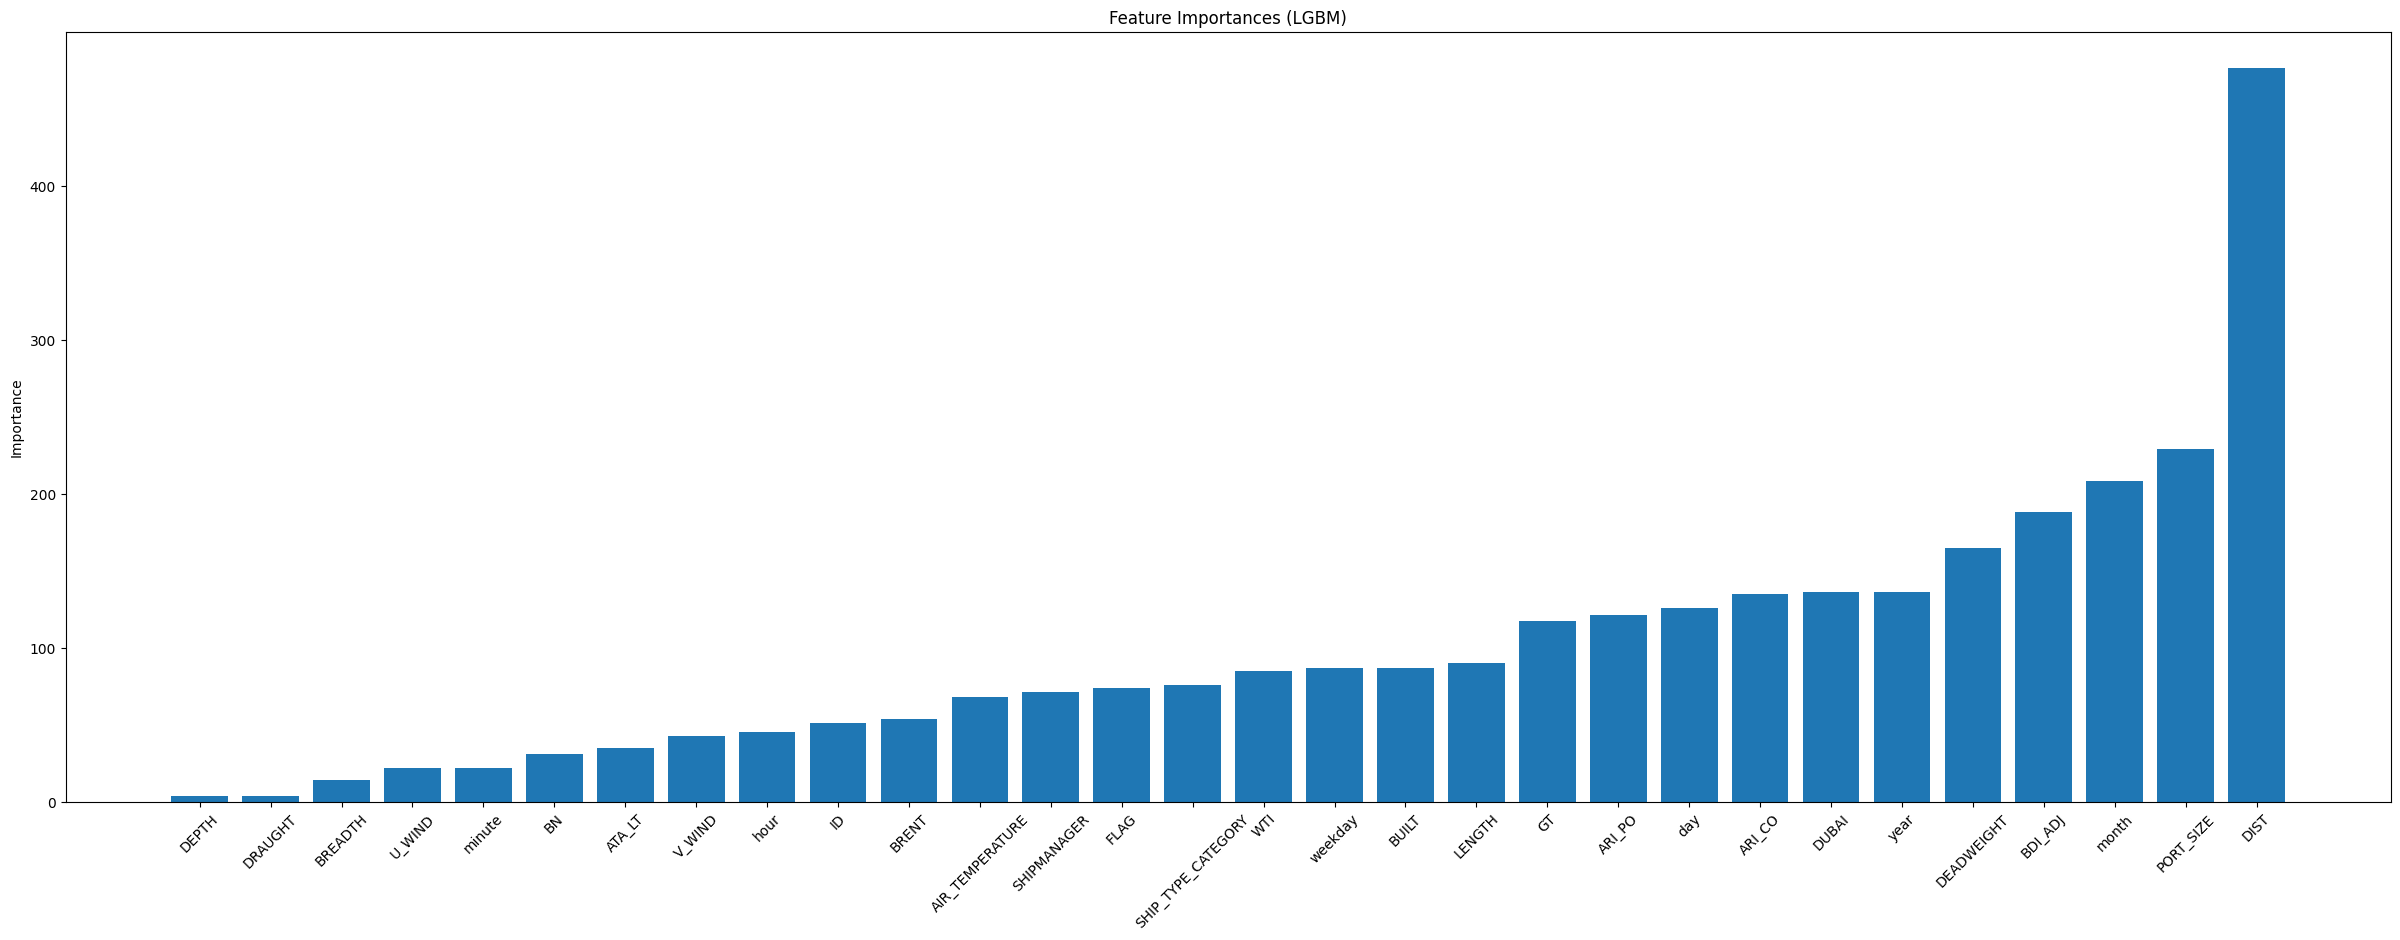

In [5]:
def train_and_evaluate(model, model_name, X_train, y_train):
    print(f'Model Tune for {model_name}.')
    model.fit(X_train, y_train)

    feature_importances = model.feature_importances_
    sorted_idx = feature_importances.argsort()

    # 그래프 크기와 타이틀 변경
    plt.figure(figsize=(len(X_train.columns), 10))  # 가로 세로 길이 변경
    plt.title(f"Feature Importances ({model_name})")

    # barh를 bar로 변경하여 세로 막대 그래프 생성
    plt.bar(range(X_train.shape[1]), feature_importances[sorted_idx], align='center')

    # xticks로 변경하여 x축에 특성 이름 표시
    plt.xticks(range(X_train.shape[1]), X_train.columns[sorted_idx], rotation=45)  # rotation 옵션으로 레이블 회전

    # x축 레이블 변경
    plt.ylabel('Importance')
    plt.show()

    return model, feature_importances

X_train = train.drop(columns='CI_HOUR')
y_train = train['CI_HOUR']

lgbm_model, lgbm_feature_importances = train_and_evaluate(lgb.LGBMRegressor(), 'LGBM', X_train, y_train)


## 특성 중요도로부터 Feature Selection

In [6]:

for importance, feature_name in zip(lgbm_feature_importances, X_train):
    print(f"Feature: {feature_name}, Importance: {importance}") 

Feature: ARI_CO, Importance: 135
Feature: ARI_PO, Importance: 121
Feature: SHIP_TYPE_CATEGORY, Importance: 76
Feature: DIST, Importance: 476
Feature: ID, Importance: 51
Feature: BREADTH, Importance: 14
Feature: BUILT, Importance: 87
Feature: DEADWEIGHT, Importance: 165
Feature: DEPTH, Importance: 4
Feature: DRAUGHT, Importance: 4
Feature: GT, Importance: 117
Feature: LENGTH, Importance: 90
Feature: SHIPMANAGER, Importance: 71
Feature: FLAG, Importance: 74
Feature: U_WIND, Importance: 22
Feature: V_WIND, Importance: 43
Feature: AIR_TEMPERATURE, Importance: 68
Feature: BN, Importance: 31
Feature: ATA_LT, Importance: 35
Feature: DUBAI, Importance: 136
Feature: BRENT, Importance: 54
Feature: WTI, Importance: 85
Feature: BDI_ADJ, Importance: 188
Feature: PORT_SIZE, Importance: 229
Feature: year, Importance: 136
Feature: month, Importance: 208
Feature: day, Importance: 126
Feature: hour, Importance: 45
Feature: minute, Importance: 22
Feature: weekday, Importance: 87


In [7]:

# "CI_HOUR"와 다른 피처들 간의 상관 계수 계산
correlations = train.corr()['CI_HOUR'].drop('CI_HOUR')

# 상관 계수 출력
print(correlations)

ARI_CO                0.005023
ARI_PO                0.000110
SHIP_TYPE_CATEGORY   -0.087319
DIST                  0.189469
ID                   -0.008730
BREADTH               0.043974
BUILT                 0.001588
DEADWEIGHT            0.078274
DEPTH                 0.052184
DRAUGHT               0.040560
GT                    0.059959
LENGTH                0.035531
SHIPMANAGER           0.002805
FLAG                  0.021008
U_WIND               -0.009567
V_WIND                0.013866
AIR_TEMPERATURE       0.027930
BN                   -0.012957
ATA_LT               -0.000283
DUBAI                 0.029129
BRENT                 0.029091
WTI                   0.029377
BDI_ADJ               0.019690
PORT_SIZE             0.020102
year                  0.020975
month                 0.003927
day                  -0.000032
hour                  0.008436
minute                0.009208
weekday               0.111973
Name: CI_HOUR, dtype: float64


In [8]:
sorted_correlations = correlations.sort_values(ascending=False)
print(sorted_correlations)


DIST                  0.189469
weekday               0.111973
DEADWEIGHT            0.078274
GT                    0.059959
DEPTH                 0.052184
BREADTH               0.043974
DRAUGHT               0.040560
LENGTH                0.035531
WTI                   0.029377
DUBAI                 0.029129
BRENT                 0.029091
AIR_TEMPERATURE       0.027930
FLAG                  0.021008
year                  0.020975
PORT_SIZE             0.020102
BDI_ADJ               0.019690
V_WIND                0.013866
minute                0.009208
hour                  0.008436
ARI_CO                0.005023
month                 0.003927
SHIPMANAGER           0.002805
BUILT                 0.001588
ARI_PO                0.000110
day                  -0.000032
ATA_LT               -0.000283
ID                   -0.008730
U_WIND               -0.009567
BN                   -0.012957
SHIP_TYPE_CATEGORY   -0.087319
Name: CI_HOUR, dtype: float64


In [9]:
threshold =  100 #Importance: 87 , deadweight
low_importance_features = X_train.columns[lgbm_feature_importances < threshold]

X_train_reduced = X_train.drop(columns=low_importance_features)
X_test_reduced = test.drop(columns=low_importance_features)

## 모델 학습 및 평가

In [ ]:

# 미리 설정한 하이퍼 파라미터
params = {
    'n_estimators': 50000,
    'max_depth': 5,
    'learning_rate': 0.2,
    'random seed':42,
    'subsample': 0.9,
    'objective': 'regression',
    'eval_metric':'mae',
    'early_stoppings' : 50
}


# 여러 feature_fraction 값을 시도해보기
feature_fractions = [ 0.88,0.9,0.95,0.98,1.0]

# K-Fold 설정
kf = KFold(n_splits=20, shuffle=True, random_state=42)

# 각 fold의 모델로부터의 예측을 저장할 리스트와 MAE 점수 리스트
ensemble_predictions = []
scores = []

# feature_fraction 값을 변경하며 학습
for feature_fraction in feature_fractions:
    params['feature_fraction'] = feature_fraction
    lgbm = lgb.LGBMRegressor(**params)
    
    fold_predictions = []
    fold_scores = []
    
    for train_idx, val_idx in tqdm(kf.split(X_train_reduced), total=20, desc=f"Processing folds for feature_fraction={feature_fraction}"):
        X_t, X_val = X_train_reduced.iloc[train_idx], X_train_reduced.iloc[val_idx]
        y_t, y_val = y_train[train_idx], y_train[val_idx]

        # 모델 학습
        lgbm.fit(X_t, y_t, eval_set=[(X_val, y_val)])

        # Validation set에 대한 예측 생성
        val_pred = lgbm.predict(X_val)

        # MAE score 계산 후 저장
        fold_scores.append(mean_absolute_error(y_val, val_pred))
        print(mean_absolute_error(y_val, val_pred))
        # Test 데이터셋에 대한 예측 수행 후 저장
        lgbm_pred = lgbm.predict(X_test_reduced)
        lgbm_pred = np.where(lgbm_pred < 0, 0, lgbm_pred)

        fold_predictions.append(lgbm_pred)
    
    # K-fold 모든 예측의 평균을 계산하여 fold별 모델들의 앙상블 예측 생성
    ensemble_predictions.append(np.mean(fold_predictions, axis=0))
    print(mean_absolute_error(y_val, val_pred))
    # 각 fold에서의 Validation Metric Score와 전체 평균 Validation Metric Score 출력
    print(f"Validation MAE scores for feature_fraction={feature_fraction}: {fold_scores}")
    print(f"Validation MAE for feature_fraction={feature_fraction}: {np.mean(fold_scores)}")

# 모든 feature_fraction에 대한 예측의 평균을 계산
final_predictions = np.mean(ensemble_predictions, axis=0)

# 최종 예측 결과 출력
print("Final predictions:", final_predictions[:10])  # 처음 10개 결과만 출력

## 결과 제출

In [ ]:
submit = pd.read_csv('.\\sample_submission.csv')
submit['CI_HOUR'] = final_predictions
submit.to_csv('.\\(42)(2023_10_10)(데이터EDA_피처셀렉션_교수님앙상블)(n_esti_100000)(LGBM)[Baseline]_피쳐_중요도_기반_Feature_Selection_&_LGBM_K_Fold_앙상블.csv', index=False)